# Plotting Wind Vectors Using Siphon, Cartopy and MetPy

In [1]:
# Construct a TDSCatalog instance pointing to the gfs dataset
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml')
print(list(best_gfs.datasets))

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Quarter Degree Forecast Time Series', 'Latest Collection for GFS Quarter Degree Forecast']


In [2]:
# Pull out the dataset you want to use and look at access URLS
best_ds = list(best_gfs.datasets.values())[1] 
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best'}

In [3]:
# Create NCSS object to access the NetcdfSubset
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

In [4]:
from datetime import datetime
# Create lat/lon box for location you want to get data for
query = ncss.query()
query.lonlat_box(north=50, south=30, east=-80, west=-115).time(datetime.utcnow())
query.accept('netcdf4')

# Request data for geopotential height
query.variables('Geopotential_height_isobaric', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(100000)
data = ncss.get_data(query)

# Pull out variables you want to use
time_var = data.variables['time']
lat_var = data.variables['lat']
lon_var = data.variables['lon']
height_var = data.variables['Geopotential_height_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']

In [5]:
import numpy as np
from netCDF4 import num2date
from metpy.calc import *
import scipy.ndimage as ndimage
from metpy.units import units

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
height = height_var[:].squeeze()
u_wind = u_wind_var[:].squeeze() * units('m/s')
v_wind = v_wind_var[:].squeeze() * units('m/s')
# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth height data
height = ndimage.gaussian_filter(height, sigma=3, order=0)

In [6]:
# Calculate geostrophic and ageostrophic wind components
geo_wind = geostrophic_wind(height * units.m, 9.15e-5 * units('s^-1'),  19993.595370802825 * units.m, 27794.3683380097 * units.m)
geo_wind_u, geo_wind_v = geo_wind[0], geo_wind[1]
ageo_wind_u = (u_wind - geo_wind_u)
ageo_wind_v = (v_wind - geo_wind_v)

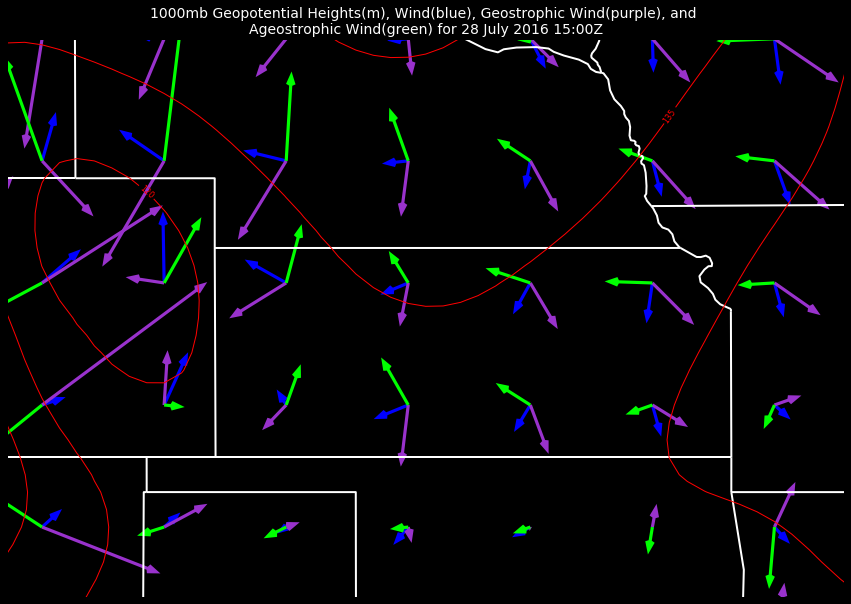

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create new figure
fig = plt.figure(figsize=(15,10), facecolor='black')

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-105., -93., 35., 43.])
ax.background_patch.set_fill(False)

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='white', linewidth=2)

# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                               scale='50m',facecolor='none')
ax.add_feature(country_borders, edgecolor='white', linewidth=2)

# Contour the pressures
c = ax.contour(lon_2d, lat_2d, height, colors='red', linewidth=4)
ax.clabel(c, fontsize=8, inline=1, inline_spacing=3, fmt='%i')

# Plot the wind vectors
wind = ax.quiver(lon_2d[0::7,0::7], lat_2d[0::7, 0::7], u_wind[0::7, 0::7], v_wind[0::7, 0::7], headlength=4, 
                 headwidth=3, angles='uv', scale_units='xy', scale=8, color='blue')
geo = ax.quiver(lon_2d[0::7, 0::7], lat_2d[0::7, 0::7], geo_wind_u[0::7, 0::7], geo_wind_v[0::7, 0::7], headlength=4,
                headwidth=3, angles='uv', scale_units='xy', scale=8, color='darkorchid')
ageo = ax.quiver(lon_2d[0::7, 0::7], lat_2d[0::7,0::7], ageo_wind_u[0::7,0::7], ageo_wind_v[0::7,0::7], headlength=4, 
                 headwidth=3, angles='uv', scale_units='xy', scale=8, color='lime')

# Add a title to the plot
plt.title('1000mb Geopotential Heights(m), Wind(blue), Geostrophic Wind(purple), and \nAgeostrophic\
 Wind(green) for {0:%d %B %Y %H:%MZ}'.format(time), color='white', size=14)